### Data Dictionary

Main columns:
- *Gender*: Gender of the person that applies for the loan (e.g., "Male" or "Female").
- *Married*: It indicates if the person it's married or not (ej., "Yes" or "No").
- *Dependents*: Amount of people that are economically dapendent of this person (e.g., 0, 1, 2, "3+").
- *Education*: Educational level of the applier (e.g., "Graduate" or "Not Graduate").
- *Self_Employed*: It indicates if the applier works independently (e.g., "Yes" or "No").
- *ApplicantIncome*: Annualy or monthly income in monetary units of the applier.
- *CoapplicantIncome*: Annualy or monthly income in monetary units of the co-applier (if exists).
- *LoanAmount*: Amount of the required load.
- *Loan_Amount_Term*: Maturity of the loan.
- *Credit_History*: Credit history indicator, 1 for good, 0 for problematic.
- *Property_Area*: Location of the property that the loan is for (e.g., "Urban", "Rural" or "Semiurban").

- *loan_status*: Output variable, indicates if the loan was approbe or not.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import sys

print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\facun\Repos\Credit_Scoring\notebooks


### Load Data

In [2]:
# Setting the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

# Importing the data loading function
from src.data_loader import load_stratified_data

# Loading the data
X_train, _, y_train, _ = load_stratified_data()

# Preparing a dataframe for EDA
df_eda = X_train.copy()
df_eda['Loan_Status'] = y_train.values

### 1. Inicial analysis

In [3]:
display(df_eda.head())

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
325,LP002067,Male,Yes,1,Graduate,Yes,8666,4983.0,376.0,360.0,0.0,Rural,0
321,LP002053,Male,Yes,3+,Graduate,No,4342,189.0,124.0,360.0,1.0,Semiurban,1
139,LP001493,Male,Yes,2,Not Graduate,No,4200,1430.0,129.0,360.0,1.0,Rural,0
251,LP001836,Female,No,2,Graduate,No,3427,0.0,138.0,360.0,1.0,Urban,0
101,LP001349,Male,No,0,Graduate,No,4843,3806.0,151.0,360.0,1.0,Semiurban,1


In [4]:
print(df_eda.info())

<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 325 to 151
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             478 non-null    object 
 2   Married            488 non-null    object 
 3   Dependents         479 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      466 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         473 non-null    float64
 9   Loan_Amount_Term   480 non-null    float64
 10  Credit_History     453 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 53.7+ KB
None


In [5]:
print("\nNull values per column:")
print(df_eda.isnull().sum())


Null values per column:
Loan_ID               0
Gender               13
Married               3
Dependents           12
Education             0
Self_Employed        25
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           18
Loan_Amount_Term     11
Credit_History       38
Property_Area         0
Loan_Status           0
dtype: int64


In [6]:
df_eda.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,491.0,5236.598778,5194.278735,150.0,2874.5,3846.0,5824.0,63337.0
CoapplicantIncome,491.0,1691.785988,3065.481180,0.0,0.0,1300.0,2333.0,41667.0
LoanAmount,473.0,148.167019,85.956899,9.0,102.0,128.0,165.0,700.0
Loan_Amount_Term,480.0,342.875000,63.657495,12.0,360.0,360.0,360.0,480.0
Credit_History,453.0,0.841060,0.366025,0.0,1.0,1.0,1.0,1.0
Loan_Status,491.0,0.686354,0.464447,0.0,0.0,1.0,1.0,1.0


**Initial Observations:**
1.  **Missing Values:** Several columns (`Gender`, `Married`, `Dependents`, `Self_Employed`, `LoanAmount`, `Loan_Amount_Term`, `Credit_History`) have missing values that need to be handled.
2.  **Data Types:** Most features are categorical (`object`) and will require encoding to be used in the model.
3.  **Scale:** The numerical features (`ApplicantIncome`, `LoanAmount`, etc.) are on very different scales, which suggests that feature scaling will be necessary for the logistic regression model to perform well.

### 2. Variables Distribution

#### 2.1. Categorical Variables

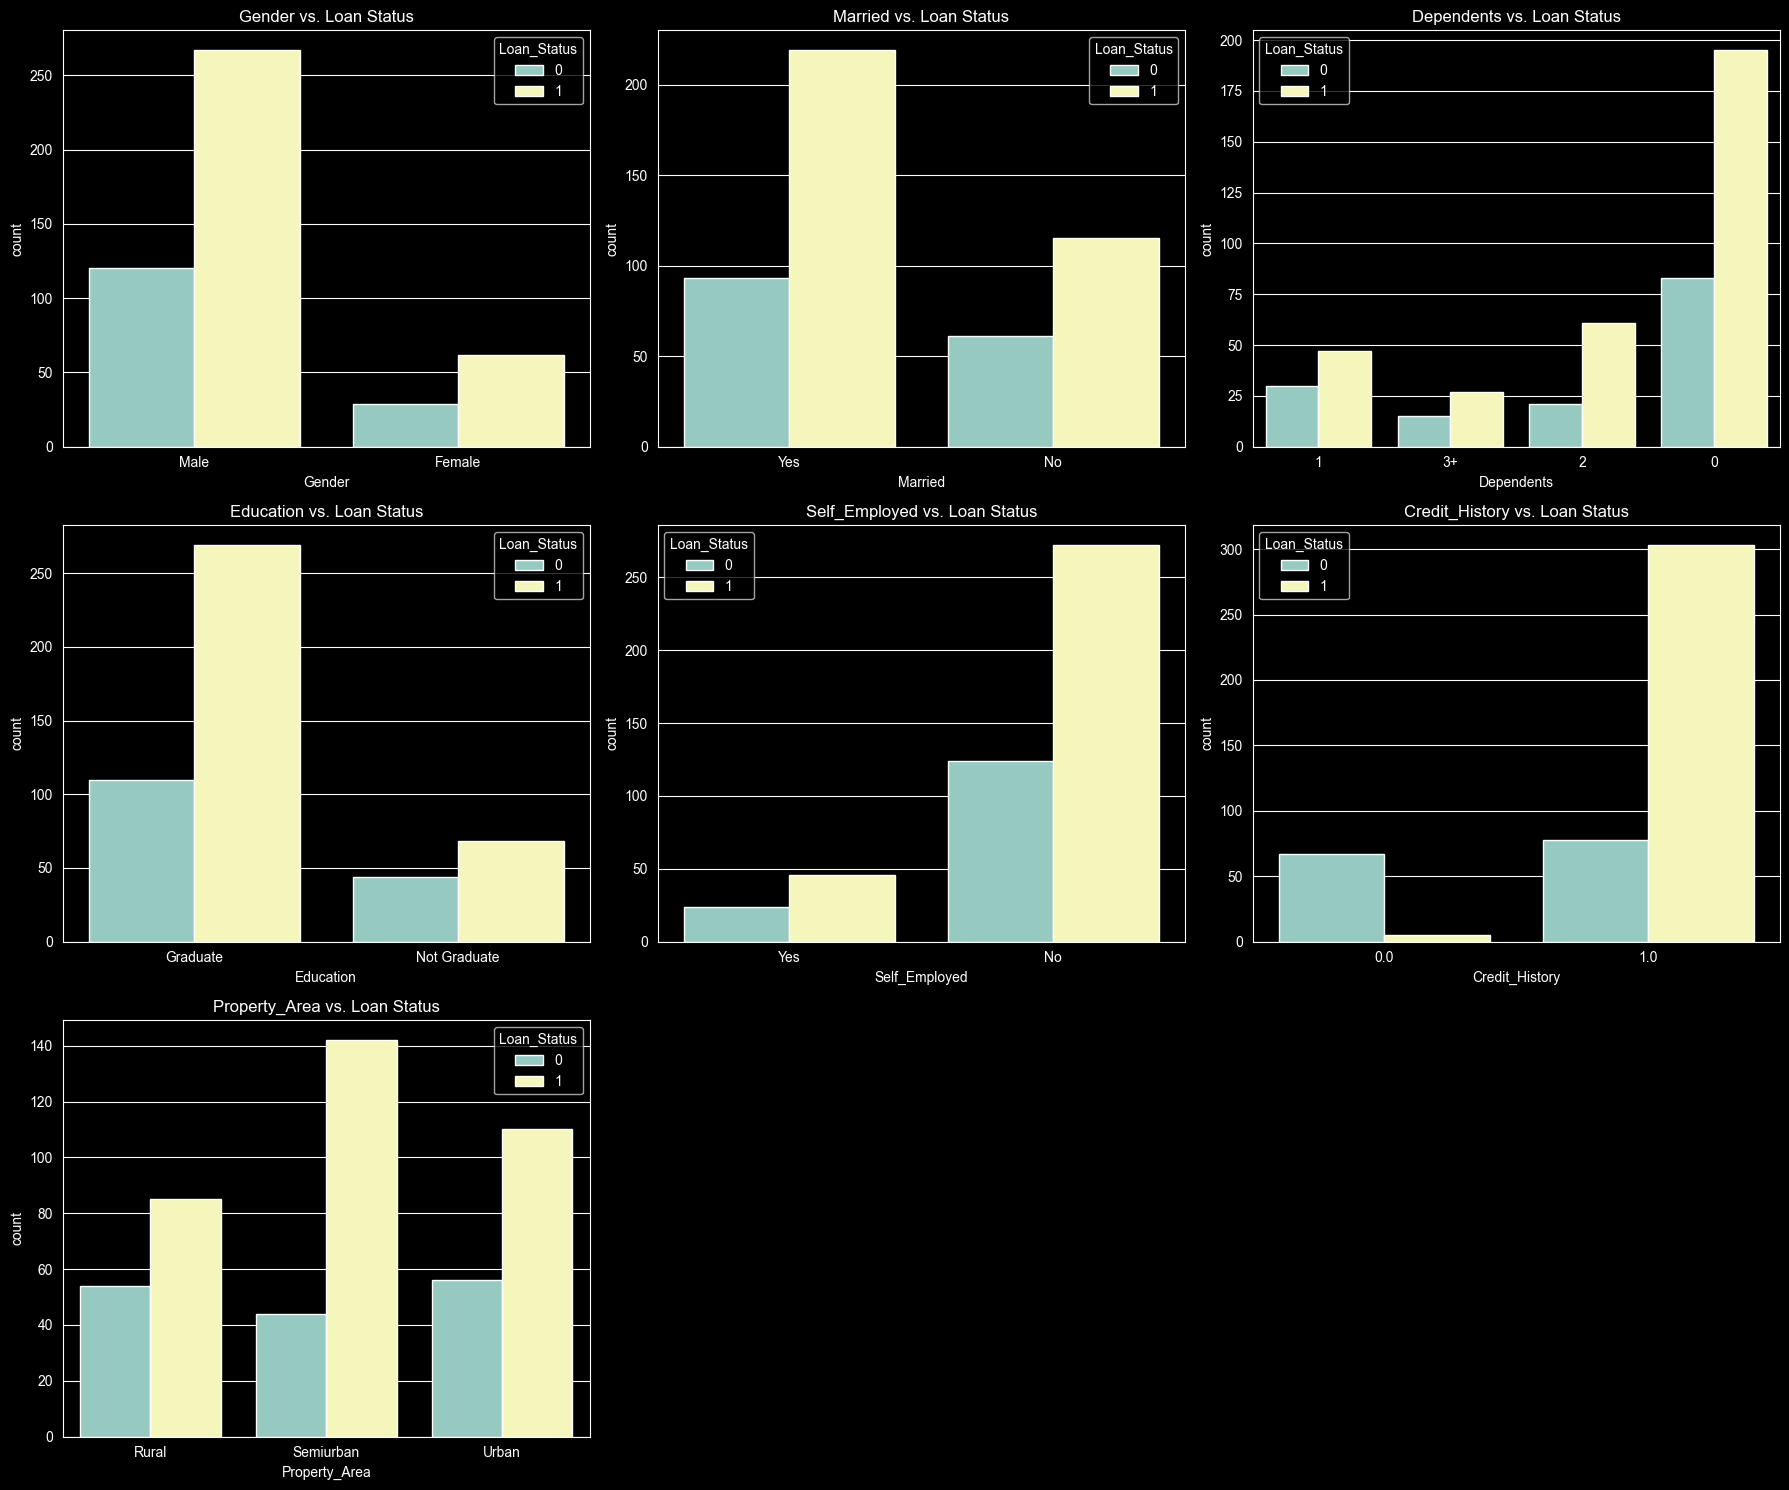

In [7]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()

# Loop to assign every feature one subplot
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Loan_Status', data=df_eda, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Loan Status')
    axes[i].tick_params(axis='x')

# Hide empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Apparently, Credit_History is a very strong predictor. People with a positive credit history (1) are approved at a much higher rate.

#### 2.2. Numerical Variables

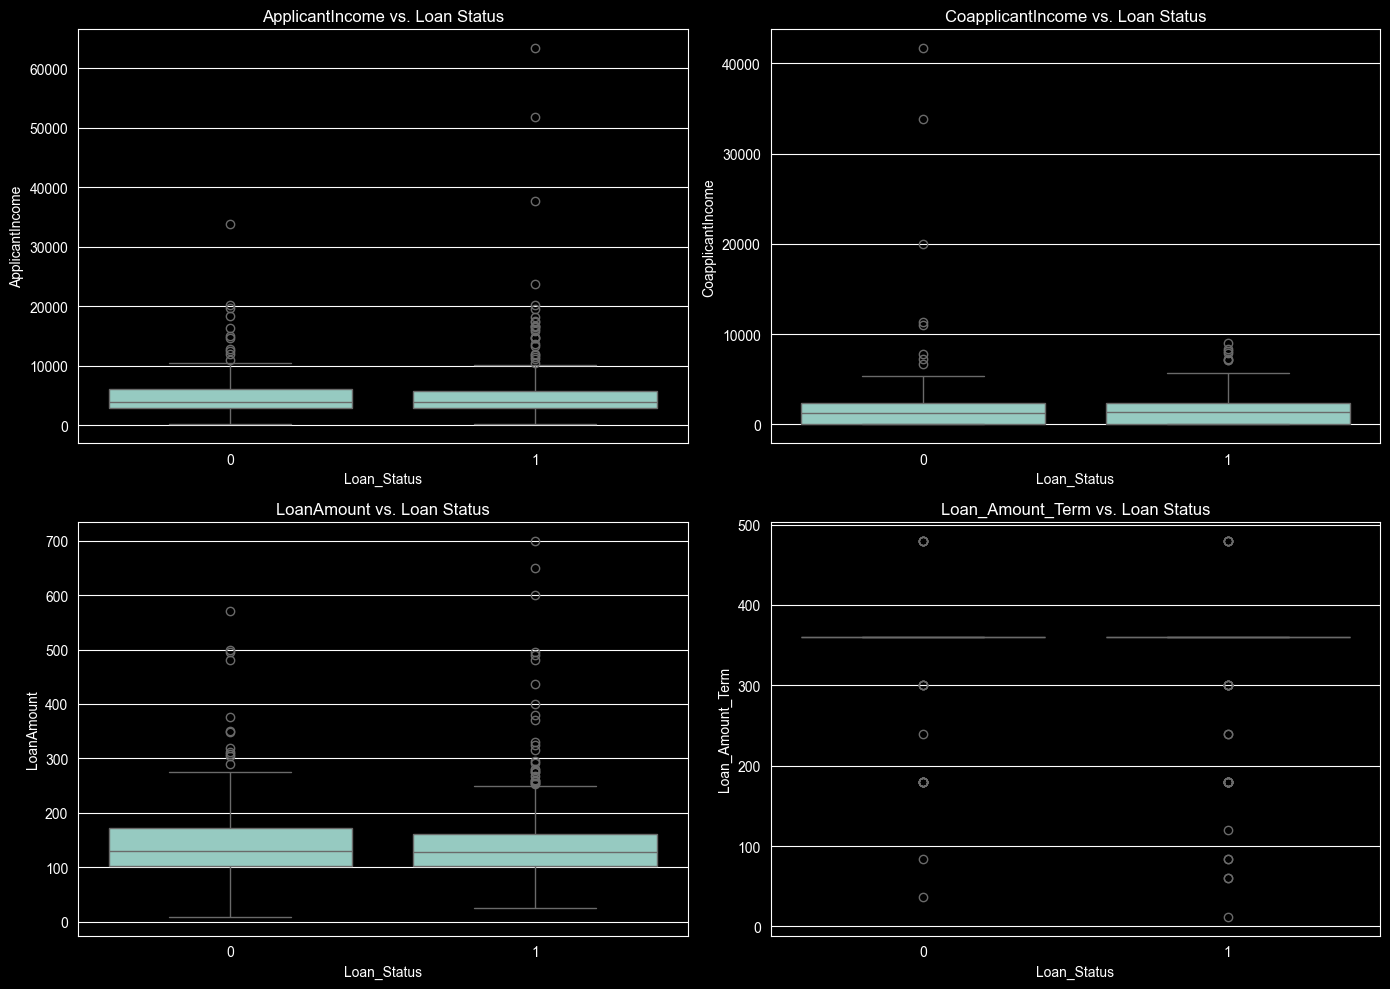

In [8]:
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Loan_Status', y=feature, data=df_eda, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Loan Status')

plt.tight_layout()
plt.show()


It can be observed that, although there are many outliers, the median ApplicantIncome does not appear to be drastically different between approved and rejected loans, suggesting that income alone may not be as decisive as other variables.

- I check its distributions:

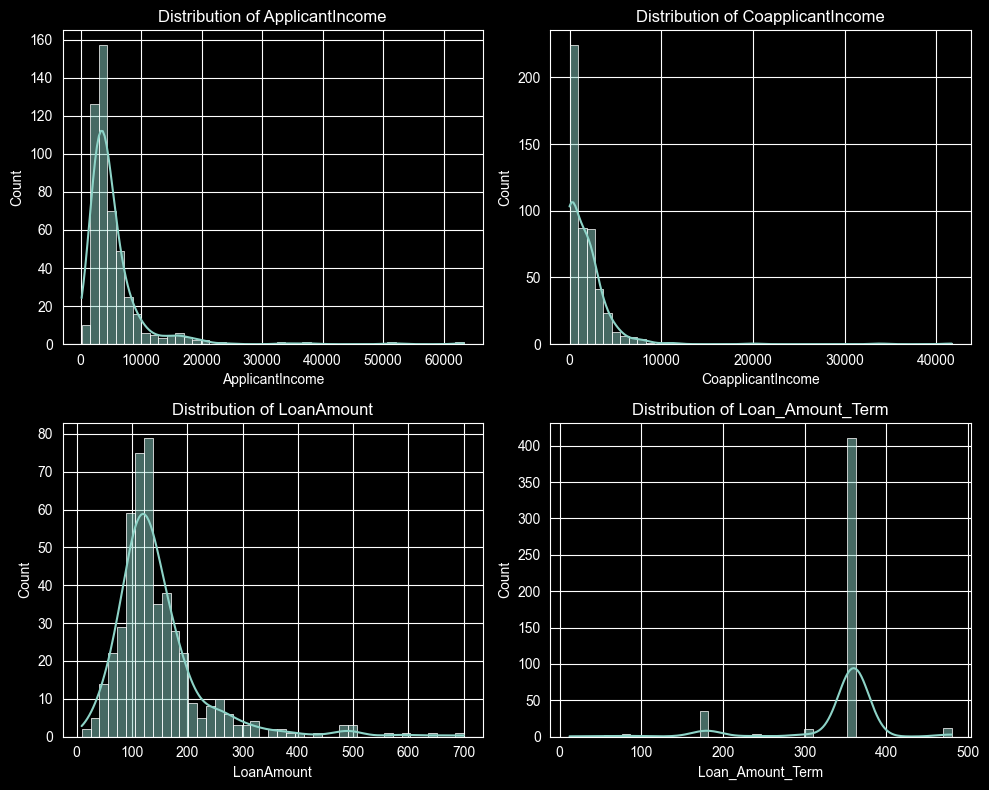

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
axes = axes.flatten()

# I create the histograms
for feature, ax in zip(features, axes):
    sns.histplot(df_eda[feature], kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In all of them, I can see a high level of asimetry that doesn't let me assume normallity, probably an StandardScaler won't be the ideal choise. Furthermore, there are a lot of categorical variables with values within 0 and 1. Because of this, I think that the ideal rescaling method is the MinMaxScaler.

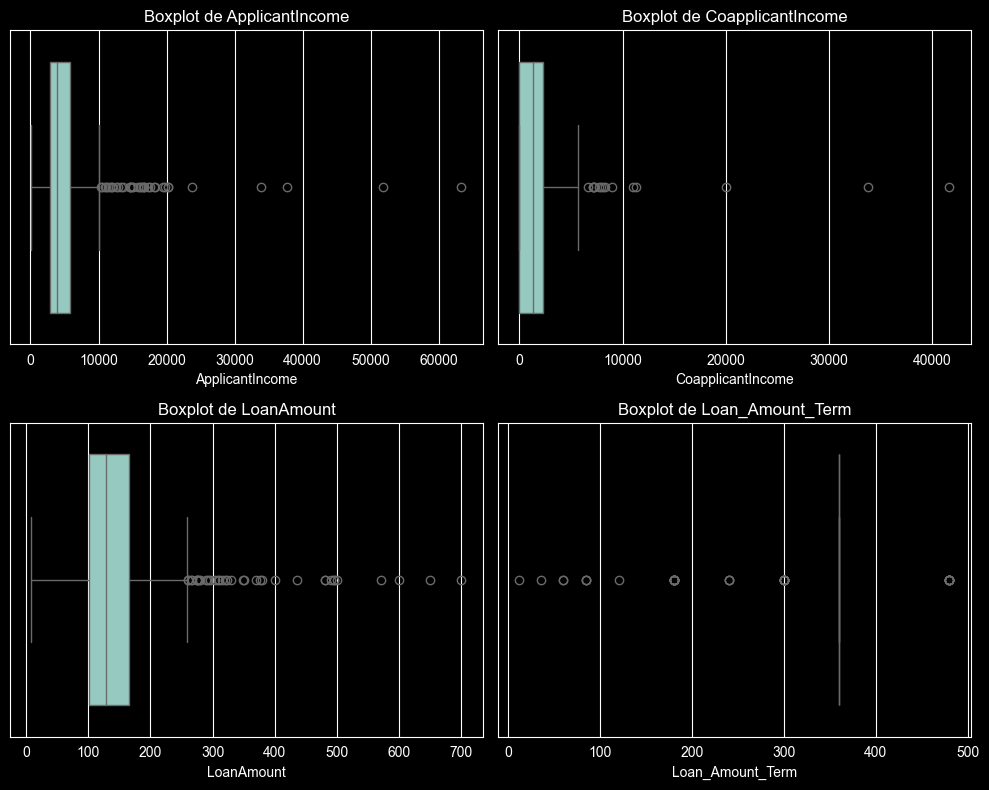

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes = axes.flatten()

# I generate the boxplots
for feature, ax in zip(features, axes):
    sns.boxplot(x=df_eda[feature], ax=ax)
    ax.set_title(f'Boxplot de {feature}')

# I adjust the design to avoid the graphics superposition
plt.tight_layout()
plt.show()

Looking at the box plots, some outliers are visible which, with a MinMax scaler, will concentrate most of the values ​​within a very small range. This could pose a problem in the future.

- I check its correlations:

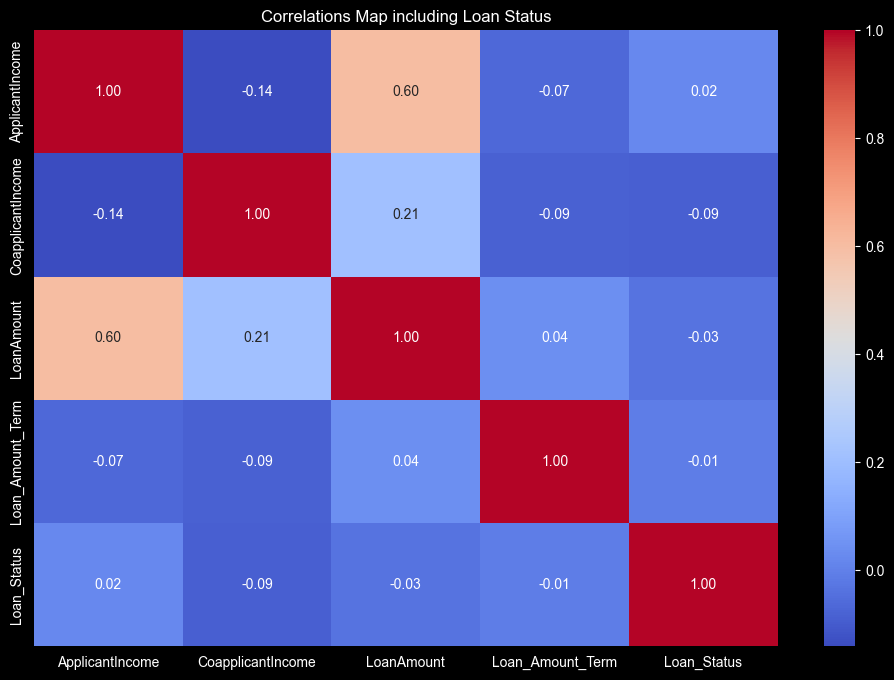

In [11]:
# Set the nuemeric columns to analyze
cols_to_corr = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Loan_Status']

plt.figure(figsize=(12, 8))
sns.heatmap(df_eda[cols_to_corr].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlations Map including Loan Status')
plt.show()

There's a clear relationship between ApplicantIncome and LoanAmount. Probably, when the income is grater, a bigger amount is required.

- I check its VIFs:

In [12]:
cols_vif = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Loan_Status']
numeric_cols_for_vif = df_eda[cols_vif].copy()

# I replace null values for the mean of each column in this temporary DataFrame
for col in numeric_cols_for_vif.columns:
    if numeric_cols_for_vif[col].isnull().any():
        numeric_cols_for_vif[col].fillna(numeric_cols_for_vif[col].mean(), inplace=True)

# I create a new column with a constant value
numeric_cols_for_vif_with_const = sm.add_constant(numeric_cols_for_vif, has_constant='add')

# I calculate the VIFs
vif_subset_data = pd.DataFrame()
vif_subset_data["Variables"] = numeric_cols_for_vif_with_const.columns
vif_subset_data["VIF"] = [variance_inflation_factor(numeric_cols_for_vif_with_const.values, i) for i in range(numeric_cols_for_vif_with_const.shape[1])]

# Print the output without taking into account the constant
print(vif_subset_data[vif_subset_data["Variables"] != "const"].round(3))

           Variables    VIF
1    ApplicantIncome  1.807
2  CoapplicantIncome  1.211
3         LoanAmount  1.844
4   Loan_Amount_Term  1.036
5        Loan_Status  1.009


I'll check for multicollinearity using the Variance Inflation Factor (VIF). A VIF value above 5 or 10 is often considered an indicator of problematic multicollinearity. In this case, it isn´t a significant problem to highlight.

#### 2.3. Target Variable

In [13]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 491 entries, 325 to 151
Series name: Loan_Status
Non-Null Count  Dtype
--------------  -----
491 non-null    int64
dtypes: int64(1)
memory usage: 7.7 KB


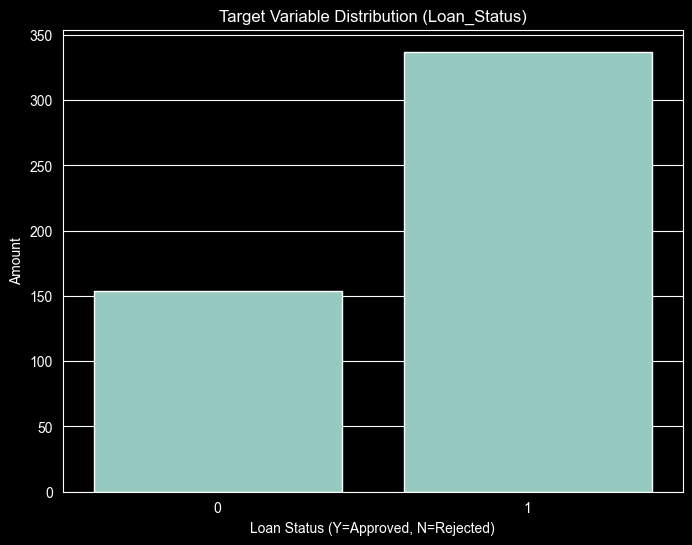

Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64


In [14]:
# Graphic with the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Target Variable Distribution (Loan_Status)')
plt.xlabel('Loan Status (Y=Approved, N=Rejected)')
plt.ylabel('Amount')
plt.show()

print(y_train.value_counts(normalize=True))

An imbalance is observed in the target variable, with 68.6% of loans being approved in the training set. This is important to consider when evaluating the model.